<a href="https://colab.research.google.com/github/replicable/ai-reg/blob/main/transparency.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from sklearn import svm

density = 400
small = 0.1
x_coord = np.linspace(-4, 4, 10)
y = [0] * density + [1] * density
cov = np.array([[1, 0], [0, 1]])

def fit(data):
  clf = svm.SVC(kernel='linear')
  clf.fit(np.concatenate((data)), y)
  boundary = [x_coord, (-clf.intercept_[0] - clf.coef_[0][0] * x_coord) / clf.coef_[0][1]]
  return clf, boundary

def game(data, clf):
  gamed_data = np.copy(data)
  for i in range(density):
    for j in [0, 1]:
      gamed_data[j][i][0] = min(max(gamed_data[j][i][0], -clf.intercept_[0] - clf.coef_[0][1] * data[j][i][1] / clf.coef_[0][0] + small), max(max(data[0][:, 0]), max(data[1][:, 0])))
  return gamed_data

def plot(data, boundary):
    plt.figure()
    plt.style.use('seaborn-dark')
    ax = plt.axes()
    ax.scatter(data[0][:, 0], data[0][:, 1], color='orange', marker='o', edgecolors='darkred', alpha=0.6)
    ax.scatter(data[1][:, 0], data[1][:, 1], color='lightblue', marker='o', edgecolors='darkblue', alpha=0.6)
    ax.plot(boundary[0], boundary[1], color='green')
    plt.xlabel('x_var')
    plt.ylabel('x_invar')
    plt.xlim(-4, 4)
    plt.ylim(-4, 4)
    plt.show()

def display_accuracy(clf, data):
  print("accuracy = " + str(clf.score(np.concatenate((data)), y)))

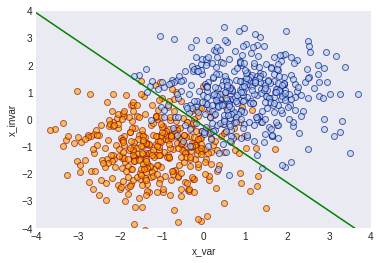

accuracy = 0.92


In [2]:
data = [multivariate_normal(cov=cov, mean=np.array([i, i]), seed=0).rvs(size=density) for i in [-1, 1]]
clf, boundary = fit(data)
plot(data, boundary)
display_accuracy(clf, data)

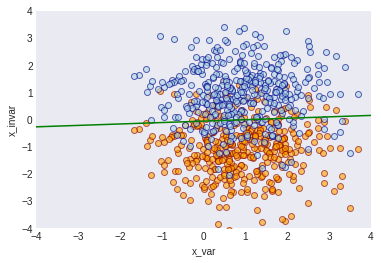

accuracy = 0.835


In [3]:
data2 = [multivariate_normal(cov=cov, mean=np.array([1, i]), seed=0).rvs(size=density) for i in [-1, 1]]
clf2, boundary2 = fit(data2)
plot(data2, boundary2)
display_accuracy(clf2, data2)

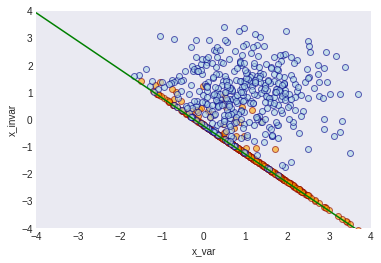

accuracy = 0.5


In [4]:
gamed_data = game(data, clf)
plot(gamed_data, boundary)
display_accuracy(clf, gamed_data)

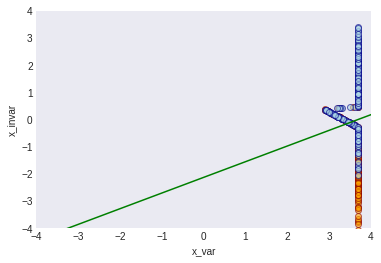

accuracy = 0.83625


In [5]:
while(True):
  updated_data = game(gamed_data, fit(gamed_data)[0])
  if np.array_equal(updated_data, gamed_data):
    break
  gamed_data = updated_data
clf, boundary = fit(updated_data)
plot(updated_data, boundary)
display_accuracy(clf, updated_data)